In [1]:
# Libraries

import argparse
import numpy
import os
import platform
import shutil
import sys

In [2]:
# Ensure source path

ROOT = os.getcwd()

while not ROOT.endswith('upolanc-thesis') :
	ROOT = os.path.abspath(os.path.join(ROOT, os.pardir))

	if len(ROOT) < len('upolanc-thesis') :
		if   platform.system() == 'Linux'   : ROOT = '/d/hpc/projects/FRI/up4472/upolanc-thesis'
		elif platform.system() == 'Windows' : ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'
		else : raise ValueError()

		print(f'Warning : could not find correct directory, using default : {ROOT}')
		print()

		break

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [3]:
# Code

from source.python.dataset.dataset_classes import GeneDataset
from source.python.cnn.models              import DenseFC2
from source.python.cnn.models              import DenseFC3

from source.python.dataset.dataset_utils import to_dataloaders
from source.python.dataset.dataset_utils import to_dataloader
from source.python.dataset.dataset_utils import to_gene_dataset
from source.python.dataset.dataset_utils import show_dataloader
from source.python.dataset.dataset_split import generate_group_shuffle_split
from source.python.dataset.dataset_split import generate_random_shuffle_split
from source.python.dataset.dataset_split import generate_stratified_shuffle_split
from source.python.dataset               import dataset_split
from source.python.dataset               import dataset_utils
from source.python.cnn                   import cnn_model
from source.python.cnn                   import cnn_plot
from source.python.cnn                   import cnn_utils
from source.python.io                    import loader
from source.python.io                    import writer
from source.python                       import runtime

runtime.set_numpy_format()
runtime.set_pandas_format()
runtime.set_plot_theme()

In [4]:
# System and device

DEVICE = runtime.get_device(only_cpu = False)
SYSTEM = runtime.get_system_info()

for key, value in SYSTEM.items() :
	print('{:25s} : {}'.format(key, value))

print()

platform/python           : 3.10.7
platform/system           : Windows
platform/release          : 10
platform/version          : 10.0.19044
platform/cpu/name         : N/A
platform/cpu/count        : 12
platform/gpu/name         : NVIDIA GeForce RTX 3060 Ti
platform/gpu/available    : True
platform/gpu/count        : 1
platform/memory/total     : 31.924 GB
platform/memory/available : 4.277 GB



# 1. Setup

In [5]:
# Define output and inputs

BERT_ARCH      = 'febert'
BERT_KMER      = '3'
BERT_SEQUENCE  = 'promoter-512'
BERT_TARGET    = 'global-mean'

MODEL_ARCH     = 'fc3'
MODEL_MODE     = 'regression'
MODEL_PARAMS   = None
MODEL_EPOCHS   = 50

FILTER_ID      = 2
VERBOSE        = False

In [6]:
# Check for args

if __name__ == '__main__' and 'get_ipython' in dir() :
	print('Running as .ipynb')
	print()

if __name__ == '__main__' and 'get_ipython' not in dir() :
	print('Running as .py')
	print()

	parser = argparse.ArgumentParser()

	str_of_bool = lambda x : True if x == 'true' else False
	str_or_none = lambda x : None if x == 'none' else str(x)
	int_or_none = lambda x : None if x == 'none' else int(x)

	parser.add_argument('--bert_arch',     type = str,         default = 'febert',       choices = ['febert'])
	parser.add_argument('--bert_kmer',     type = str,         default = '3',            choices = ['3', '6'])
	parser.add_argument('--bert_sequence', type = str,         default = 'promoter-512', choices = ['promoter-512', 'promoter-4096', 'promoter-utr5-4096'])
	parser.add_argument('--bert_target',   type = str,         default = 'global-mean',  choices = ['global-mean', 'tissue-mean-explode', 'group-mean-explode'])
	parser.add_argument('--model_epochs',  type = int,         default = 50)
	parser.add_argument('--model_params',  type = int_or_none, default = None)
	parser.add_argument('--model_mode',    type = str,         default = 'regression',   choices = ['regression', 'classification'])
	parser.add_argument('--model_arch',    type = str,         default = 'fc2',          choices = ['fc2', 'fc3'])
	parser.add_argument('--filter_id',     type = int,         default = 0)

	args = vars(parser.parse_args())

	BERT_ARCH     = args['bert_arch']
	BERT_KMER     = args['bert_kmer']
	BERT_SEQUENCE = args['bert_sequence']
	BERT_TARGET   = args['bert_target']
	MODEL_EPOCHS  = args['model_epochs']
	MODEL_PARAMS  = args['model_params']
	MODEL_MODE    = args['model_mode']
	MODEL_ARCH    = args['model_arch']
	FILTER_ID     = args['filter_id']

TARGET_GROUP   = BERT_TARGET.split('-')[0]
TARGET_TYPE    = BERT_TARGET.split('-')[1]
TARGET_EXPLODE = False
TARGET_FILTER  = None

if len(BERT_TARGET.split('-')) == 3 :
	TARGET_EXPLODE = True

	if BERT_TARGET.split('-')[2] != 'explode' :
		TARGET_FILTER  = BERT_TARGET.split('-')[2]

Running as .ipynb



In [7]:
# Setup some directory paths.

SUBFOLDER = 'filter' + str(FILTER_ID)
DNAFOLDER = os.path.join(BERT_ARCH, BERT_KMER, BERT_SEQUENCE, BERT_TARGET)

CWD = ROOT
OUT = os.path.join(CWD, 'output')
RES = os.path.join(CWD, 'resources')

OUT_DATA  = os.path.join(OUT,      'nbp12-bert', 'cnn',  SUBFOLDER, DNAFOLDER)
OUT_MODEL = os.path.join(OUT_DATA, 'model')
OUT_PLOT  = os.path.join(OUT_DATA, 'plot')
RES_NBP05 = os.path.join(OUT,      'nbp05-target',       SUBFOLDER)
RES_BERT  = os.path.join(OUT,      'nbp12-bert', 'bert', SUBFOLDER, DNAFOLDER)

shutil.rmtree(OUT_DATA, ignore_errors = True)

os.makedirs(OUT_DATA,  exist_ok = True)
os.makedirs(OUT_MODEL, exist_ok = True)
os.makedirs(OUT_PLOT,  exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT_DATA}')
print(f'   Output Directory : {OUT_MODEL}')
print(f'   Output Directory : {OUT_PLOT}')
print(f' Resource Directory : {RES_NBP05}')
print(f' Resource Directory : {RES_BERT}')
print()

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp12-bert\cnn\filter2\febert\3\promoter-512\global-mean
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp12-bert\cnn\filter2\febert\3\promoter-512\global-mean\model
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp12-bert\cnn\filter2\febert\3\promoter-512\global-mean\plot
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp05-target\filter2
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp12-bert\bert\filter2\febert\3\promoter-512\global-mean



In [8]:
# Load the input transcript features

target_order = loader.load_json(
	filename = os.path.join(RES_NBP05, 'target-order.json')
)[TARGET_GROUP]

# 2. Config

In [9]:
# Create final report

final_report = dict()

In [10]:
# Single global config

CONFIG = {
	'core/device'                  : DEVICE,
	'core/random'                  : None,
	'core/rootdir'                 : ROOT,
	'core/subfolder'               : SUBFOLDER,
	'core/verbose'                 : VERBOSE,
	'core/plots'                   : 10,
	'criterion/name'               : None,
	'criterion/reduction'          : 'mean',
	'dataset/batch/test'           : 32,
	'dataset/batch/train'          : 32,
	'dataset/batch/valid'          : 32,
	'dataset/expanddim'            : None,
	'dataset/split/generator'      : 'random',
	'dataset/split/test'           : 0.2,
	'dataset/split/valid'          : 0.2,
	'model/dropout'                : 0.1765226268206447,
	'model/epochs'                 : MODEL_EPOCHS,
	'model/fc1/features'           : 256,
	'model/fc2/features'           : 512,
	'model/fc3/features'           : None,
	'model/fc3/heads'              : None,
	'model/input/features'         : None,
	'model/leakyrelu'              : 0.0020041426157843,
	'model/name'                   : MODEL_ARCH,
	'model/mode'                   : MODEL_MODE,
	'model/output/explode'         : TARGET_EXPLODE,
	'model/output/filter'          : TARGET_FILTER,
	'model/output/heads'           : None,
	'model/output/size'            : None,
	'model/output/target'          : TARGET_GROUP,
	'model/output/type'            : TARGET_TYPE,
	'model/params/id'              : MODEL_PARAMS,
	'optimizer/beta1'              : 0.8848748334600965,
	'optimizer/beta2'              : 0.9823702296400402,
	'optimizer/decay'              : 0.0018856990147678,
	'optimizer/lr'                 : 5e-5,
	'optimizer/name'               : 'adam',
	'scheduler/exponential/factor' : 0.9790452724955196,
	'scheduler/name'               : 'exponential'
}

CONFIG['core/random'] = runtime.lock_random(
	seed     = CONFIG['core/random'],
	generate = True
)

In [11]:
# Configure criterion

if CONFIG['model/mode'] == 'regression'     : CONFIG['criterion/name'] = 'corrected-mse'
if CONFIG['model/mode'] == 'classification' : CONFIG['criterion/name'] = 'entropy'

In [12]:
# Prints

print('Output Target : {}'.format(CONFIG['model/output/target']))
print('Output Type   : {}'.format(CONFIG['model/output/type']))
print('Random Seed   : {}'.format(CONFIG['core/random']))
print()

Output Target : global
Output Type   : mean
Random Seed   : 648964925



# 3. Dataloader

## 3.1 Load Batches

In [13]:
# Define arrays and folder

sorter = lambda x : int(x.split('_')[-1].split('.')[0])

x_outputs  = None
x_features = None
x_labels   = None

y_outputs  = None
y_features = None
y_labels   = None

In [14]:
# Load and concatenate batches

for root, _, files in os.walk(RES_BERT) :
	print('Root : {}'.format(root))
	print()

	x_files = [x for x in files if x.startswith('train_') and x.endswith('.npz')]
	y_files = [x for x in files if x.startswith('dev_')   and x.endswith('.npz')]

	x_files = sorted(x_files, key = sorter)
	y_files = sorted(y_files, key = sorter)

	for i, x in enumerate(x_files) :
		mat = numpy.load(os.path.join(root, x))

		if i == 0 :
			x_outputs  = mat['outputs']
			x_features = mat['features']
			x_labels   = mat['labels']
		else :
			x_outputs  = numpy.concatenate((x_outputs,  mat['outputs']),  axis = 0)
			x_features = numpy.concatenate((x_features, mat['features']), axis = 0)
			x_labels   = numpy.concatenate((x_labels,   mat['labels']),   axis = 0)

	for i, y in enumerate(y_files) :
		mat = numpy.load(os.path.join(root, y))

		if i == 0 :
			y_outputs  = mat['outputs']
			y_features = mat['features']
			y_labels   = mat['labels']
		else :
			y_outputs  = numpy.concatenate((y_outputs,  mat['outputs']),  axis = 0)
			y_features = numpy.concatenate((y_features, mat['features']), axis = 0)
			y_labels   = numpy.concatenate((y_labels,   mat['labels']),   axis = 0)

Root : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp12-bert\bert\filter2\febert\3\promoter-512\global-mean



In [15]:
# Merge outputs and features

x_features = numpy.concatenate((x_outputs, x_features), axis = 1)
y_features = numpy.concatenate((y_outputs, y_features), axis = 1)

if numpy.ndim(x_labels) == 1 : x_labels = numpy.expand_dims(x_labels, axis = 1)
if numpy.ndim(y_labels) == 1 : y_labels = numpy.expand_dims(y_labels, axis = 1)

print('Training :')
print('Features : {}'.format(numpy.shape(x_features)))
print('Labels   : {}'.format(numpy.shape(x_labels)))
print()

print('Testing  :')
print('Features : {}'.format(numpy.shape(y_features)))
print('Labels   : {}'.format(numpy.shape(y_labels)))
print()

Training :
Features : (16368, 840)
Labels   : (16368, 1)

Testing  :
Features : (4092, 840)
Labels   : (4092, 1)



In [16]:
# Update configuration

CONFIG['model/input/features'] = numpy.shape(x_features)[1]
CONFIG['model/output/size']    = numpy.shape(x_labels)[1]

print('Input Features : {}'.format(CONFIG['model/input/features']))
print('Output Size    : {}'.format(CONFIG['model/output/size']))
print('Output Heads   : {}'.format(CONFIG['model/output/heads']))
print()

CONFIG['model/fc3/features'] = CONFIG['model/output/size']
CONFIG['model/fc3/heads']    = CONFIG['model/output/heads']

Input Features : 840
Output Size    : 1
Output Heads   : None



In [17]:
# Convert to same datatype

to_double = lambda x : x.astype(numpy.float64)
to_float  = lambda x : x.astype(numpy.float32)
to_common = to_double
to_empty  = lambda : to_common(numpy.array(0))

x_features = to_common(x_features)
x_labels   = to_common(x_labels)

y_features = to_common(y_features)
y_labels   = to_common(y_labels)

In [18]:
# Convert into my format

cf = lambda x : 'G{:04d}'.format(x)

train_indices   = [i for i in range(numpy.shape(x_labels)[0])]

train_names     = [cf(i)                 for i in train_indices]
train_sequences = {cf(i) : to_empty()    for i in train_indices}
train_features  = {cf(i) : x_features[i] for i in train_indices}
train_targets   = {cf(i) : x_labels[i]   for i in train_indices}

test_indices   = [i for i in range(numpy.shape(y_labels)[0])]

test_names     = [cf(i)                 for i in test_indices]
test_sequences = {cf(i) : to_empty()    for i in test_indices}
test_features  = {cf(i) : y_features[i] for i in test_indices}
test_targets   = {cf(i) : y_labels[i]   for i in test_indices}

## 3.2 Create Dataset

In [19]:
# Create train and valid dataloader

train_dataset = GeneDataset(
	names       = train_names,
	sequences   = train_sequences,
	features    = train_features,
	targets     = train_targets,
	onehot      = False,
	expand_dims = None,
	groups      = train_indices,
	start       = None,
	end         = None
)

dataloaders = to_dataloaders(
	dataset     = train_dataset,
	generator   = CONFIG['dataset/split/generator'],
	random_seed = CONFIG['core/random'],
	split_size  = {
		'valid' : CONFIG['dataset/split/test'],
		'test'  : CONFIG['dataset/split/valid']
	},
	batch_size  = {
		'train' : CONFIG['dataset/batch/train'],
		'valid' : CONFIG['dataset/batch/test'],
		'test'  : CONFIG['dataset/batch/valid']
	}
)

train_dataloader = dataloaders[0]
valid_dataloader = dataloaders[2]

In [20]:
# Display train dataloader

show_dataloader(
	dataloader = train_dataloader,
	verbose    = CONFIG['core/verbose']
)

In [21]:
# Display valid dataloader

show_dataloader(
	dataloader = valid_dataloader,
	verbose    = CONFIG['core/verbose']
)

In [22]:
# Create test dataloader

test_dataset = GeneDataset(
	names       = test_names,
	sequences   = test_sequences,
	features    = test_features,
	targets     = test_targets,
	onehot      = False,
	expand_dims = None,
	groups      = test_indices,
	start       = None,
	end         = None
)

test_dataloader = to_dataloader(
	dataset    = test_dataset,
	indices    = test_indices,
	batch_size = CONFIG['dataset/batch/test']
)

In [23]:
# Display test dataloader

show_dataloader(
	dataloader = test_dataloader,
	verbose    = CONFIG['core/verbose']
)

# 4. Model

## 4.1 Structure

In [24]:
# Create and display the model structure

if CONFIG['model/name'] == 'fc2' : model = DenseFC2
if CONFIG['model/name'] == 'fc3' : model = DenseFC3

if CONFIG['model/name'] == 'fc2' : hidden = [CONFIG['model/fc1/features']]
if CONFIG['model/name'] == 'fc3' : hidden = [CONFIG['model/fc1/features'], CONFIG['model/fc2/features']]

model = model(
	input_size  = CONFIG['model/input/features'],
	output_size = CONFIG['model/output/size'],
	hidden_size = hidden,
	dropout     = CONFIG['model/dropout'],
	leaky_relu  = CONFIG['model/leakyrelu']
)

print(model.summary(
	batch_size = CONFIG['dataset/batch/train'],
	input_size = CONFIG['model/input/features']
))

print()

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
DenseFC3                                 [32, 840]                 [32, 1]                   --
├─Linear: 1-1                            [32, 840]                 [32, 256]                 215,296
├─LeakyReLU: 1-2                         [32, 256]                 [32, 256]                 --
├─Dropout: 1-3                           [32, 256]                 [32, 256]                 --
├─Linear: 1-4                            [32, 256]                 [32, 512]                 131,584
├─LeakyReLU: 1-5                         [32, 512]                 [32, 512]                 --
├─Dropout: 1-6                           [32, 512]                 [32, 512]                 --
├─Linear: 1-7                            [32, 512]                 [32, 1]                   513
Total params: 347,393
Trainable params: 347,393
Non-trainable params: 0
Total mult-adds (M): 11.12
Input size (MB): 0.11

In [25]:
# Convert the model to double and initialize weights and biases

model = model.double()
model = model.apply(cnn_model.he_uniform_weight)
model = model.apply(cnn_model.zero_bias)

## 4.2 Metrics

In [26]:
# Define metrics

if CONFIG['model/mode'] == 'regression' :
	METRICS = {
		'mse'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mse'),
		'mae'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mae'),
		'smae'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'smae'),
		'mape'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mape',  output_size = CONFIG['model/output/size']),
		'wmape' : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'wmape', output_size = CONFIG['model/output/size']),
		'r2'    : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'r2',    output_size = CONFIG['model/output/size']),
	}

if CONFIG['model/mode'] == 'classification' :
	METRICS = {
		'entropy'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'entropy'),
		'accuracy'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'accuracy',  task = 'multiclass', n_classes = CONFIG['model/output/size']),
		'auroc'     : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'auroc',     task = 'multiclass', n_classes = CONFIG['model/output/size']),
		'confusion' : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'confusion', task = 'multiclass', n_classes = CONFIG['model/output/size']),
		'f1'        : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'f1',        task = 'multiclass', n_classes = CONFIG['model/output/size']),
		'jaccardi'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'jaccardi',  task = 'multiclass', n_classes = CONFIG['model/output/size']),
		'matthews'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'matthews',  task = 'multiclass', n_classes = CONFIG['model/output/size'])
	}

METRICS = {
	k : v.to(DEVICE)
	for k, v in METRICS.items()
}

## 4.2 Parameters

In [27]:
# Set the model parameters

model_trainers = cnn_model.get_model_trainers(
	model  = model,
	config = CONFIG,
	epochs = CONFIG['model/epochs']
)

model_params = {
	'model'     : model,
	'savebest'  : os.path.join(OUT_MODEL, f'{model.__name__}-best.pth'),
	'savelast'  : os.path.join(OUT_MODEL, f'{model.__name__}-last.pth'),
	'savetime'  : os.path.join(OUT_MODEL, f'{model.__name__}-time.pth'),
	'epochs'    : CONFIG['model/epochs'],
	'criterion' : model_trainers['criterion'],
	'optimizer' : model_trainers['optimizer'],
	'scheduler' : model_trainers['scheduler'],
	'device'    : DEVICE,
	'verbose'   : CONFIG['core/verbose'],
	'metrics'   : METRICS,
	'train_dataloader' : train_dataloader,
	'valid_dataloader' : valid_dataloader,
	'test_dataloader'  : test_dataloader
}

## 4.3 Train

In [28]:
# Train and validate the model

if CONFIG['model/mode'] == 'regression' :
	report = cnn_model.train_regressor(
		model  = model,
		params = model_params
	)

if CONFIG['model/mode'] == 'classification' :
	report = cnn_model.train_classifier(
		model  = model,
		params = model_params
	)

## 4.4 Visualization

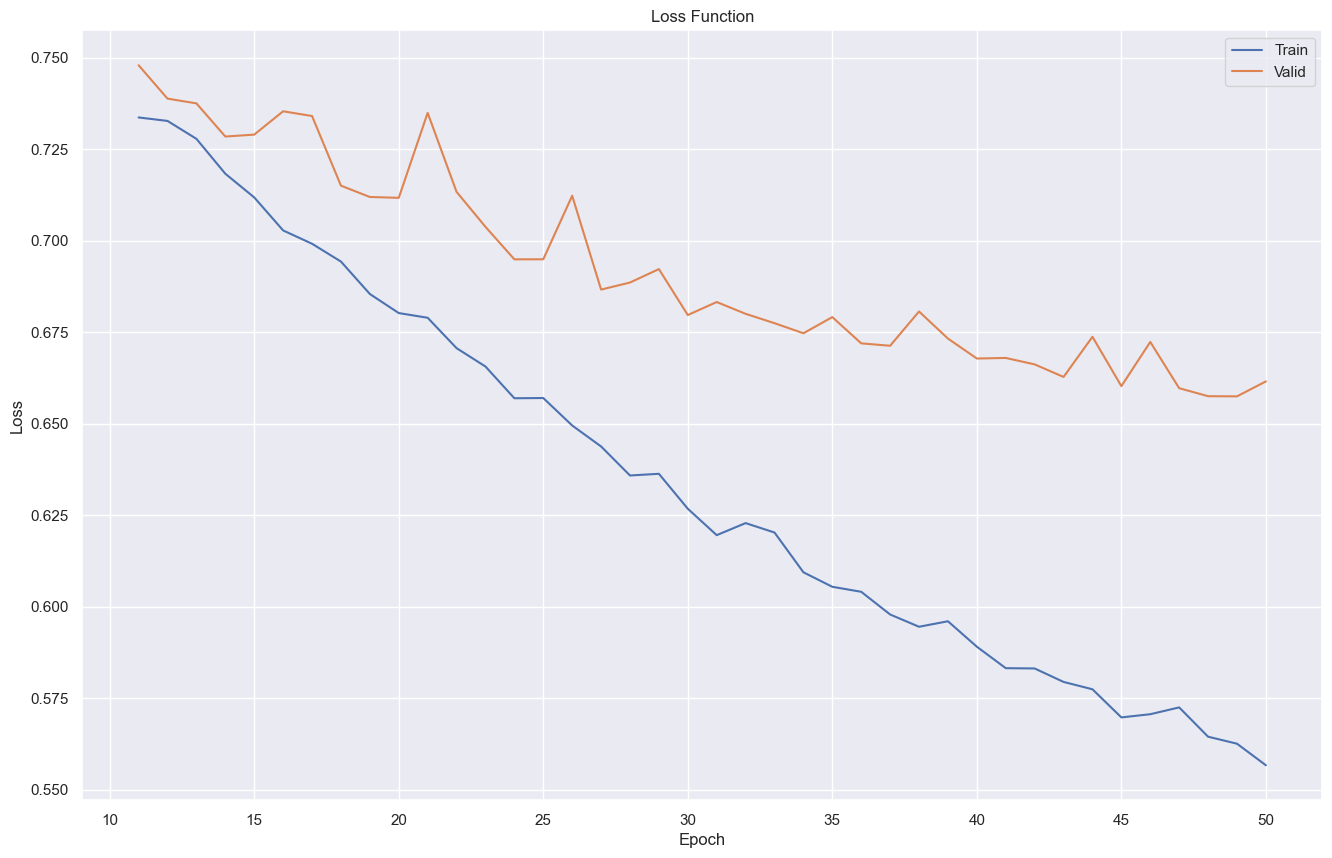

In [29]:
# Display the training and validation loss curves

cnn_plot.show_loss(
	report      = report,
	title       = 'Loss Function',
	filename    = os.path.join(OUT_PLOT, model.__name__),
	limit_bot   = None,
	limit_top   = None,
	start_index = CONFIG['core/plots']
)

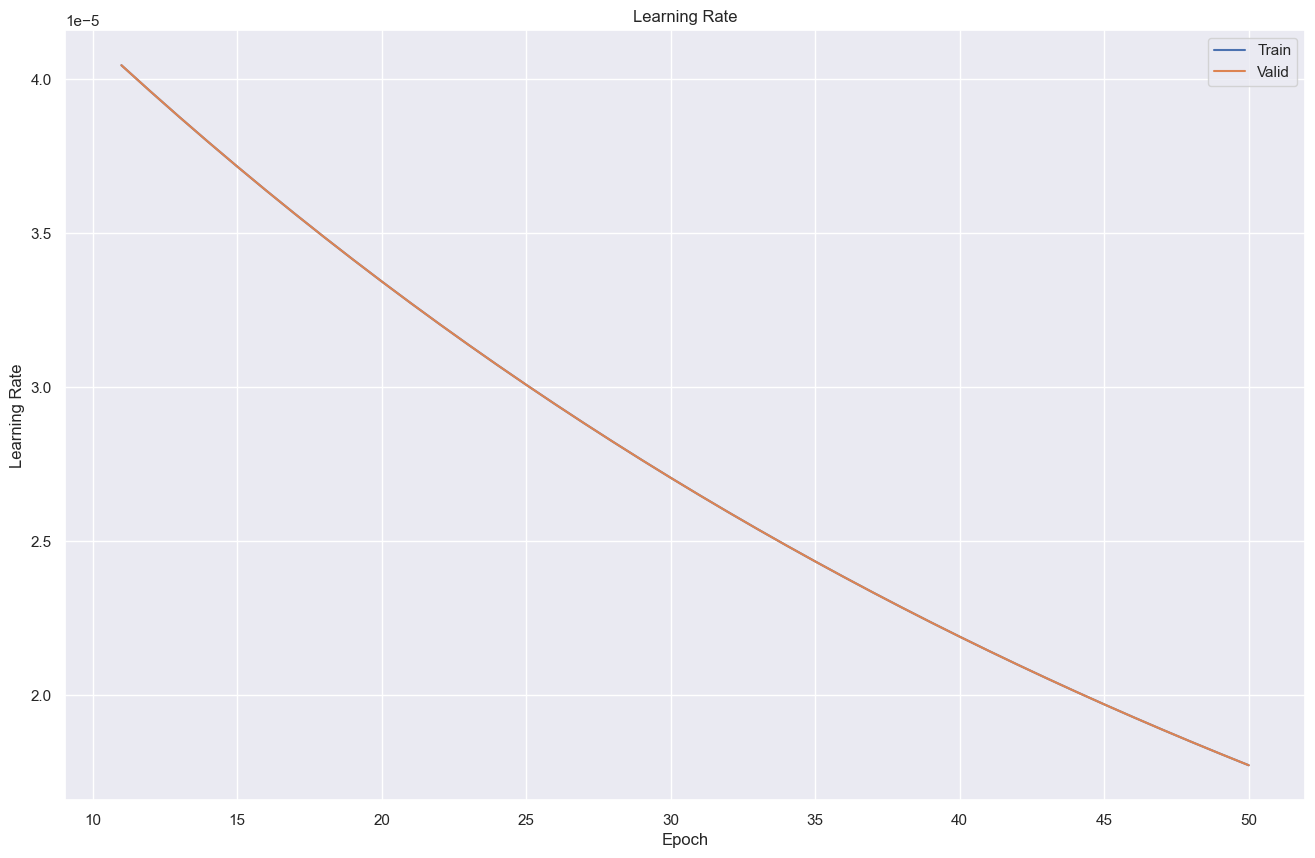

In [30]:
# Display the training and validation learning rate curves

cnn_plot.show_lr(
	report      = report,
	title       = 'Learning Rate',
	filename    = os.path.join(OUT_PLOT, model.__name__),
	limit_bot   = None,
	limit_top   = None,
	start_index = CONFIG['core/plots']
)

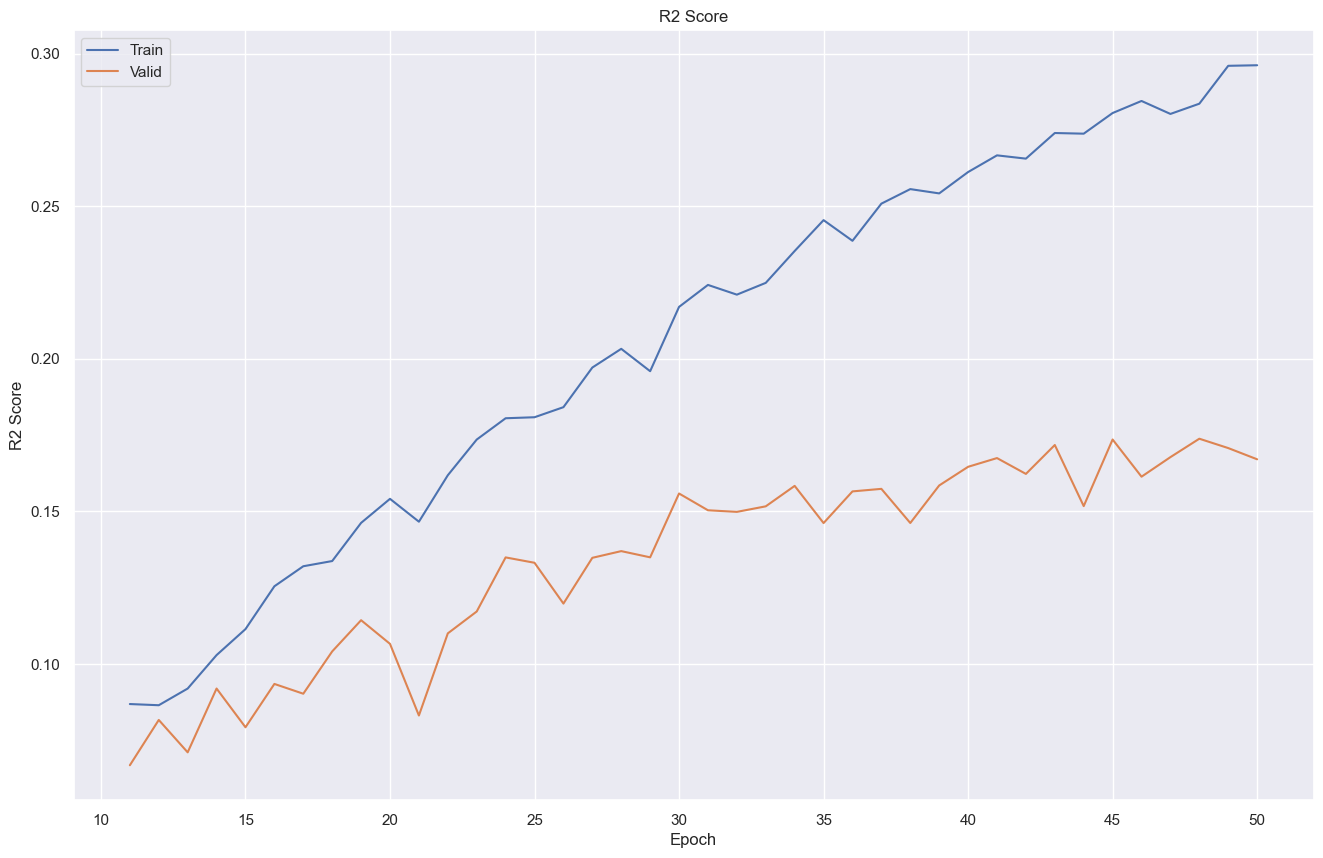

In [31]:
# Display the training and validation accuracy or r2 curves

if CONFIG['model/mode'] == 'regression' :
	cnn_plot.show_r2(
		report      = report,
		title       = 'R2 Score',
		filename    = os.path.join(OUT_PLOT, model.__name__),
		limit_bot   = None,
		limit_top   = None,
		start_index = CONFIG['core/plots']
	)

if CONFIG['model/mode'] == 'classification' :
	cnn_plot.show_accuracy(
		report      = report,
		title       = 'Accuracy',
		filename    = os.path.join(OUT_PLOT, model.__name__),
		limit_bot   = None,
		limit_top   = None,
		start_index = CONFIG['core/plots']
	)

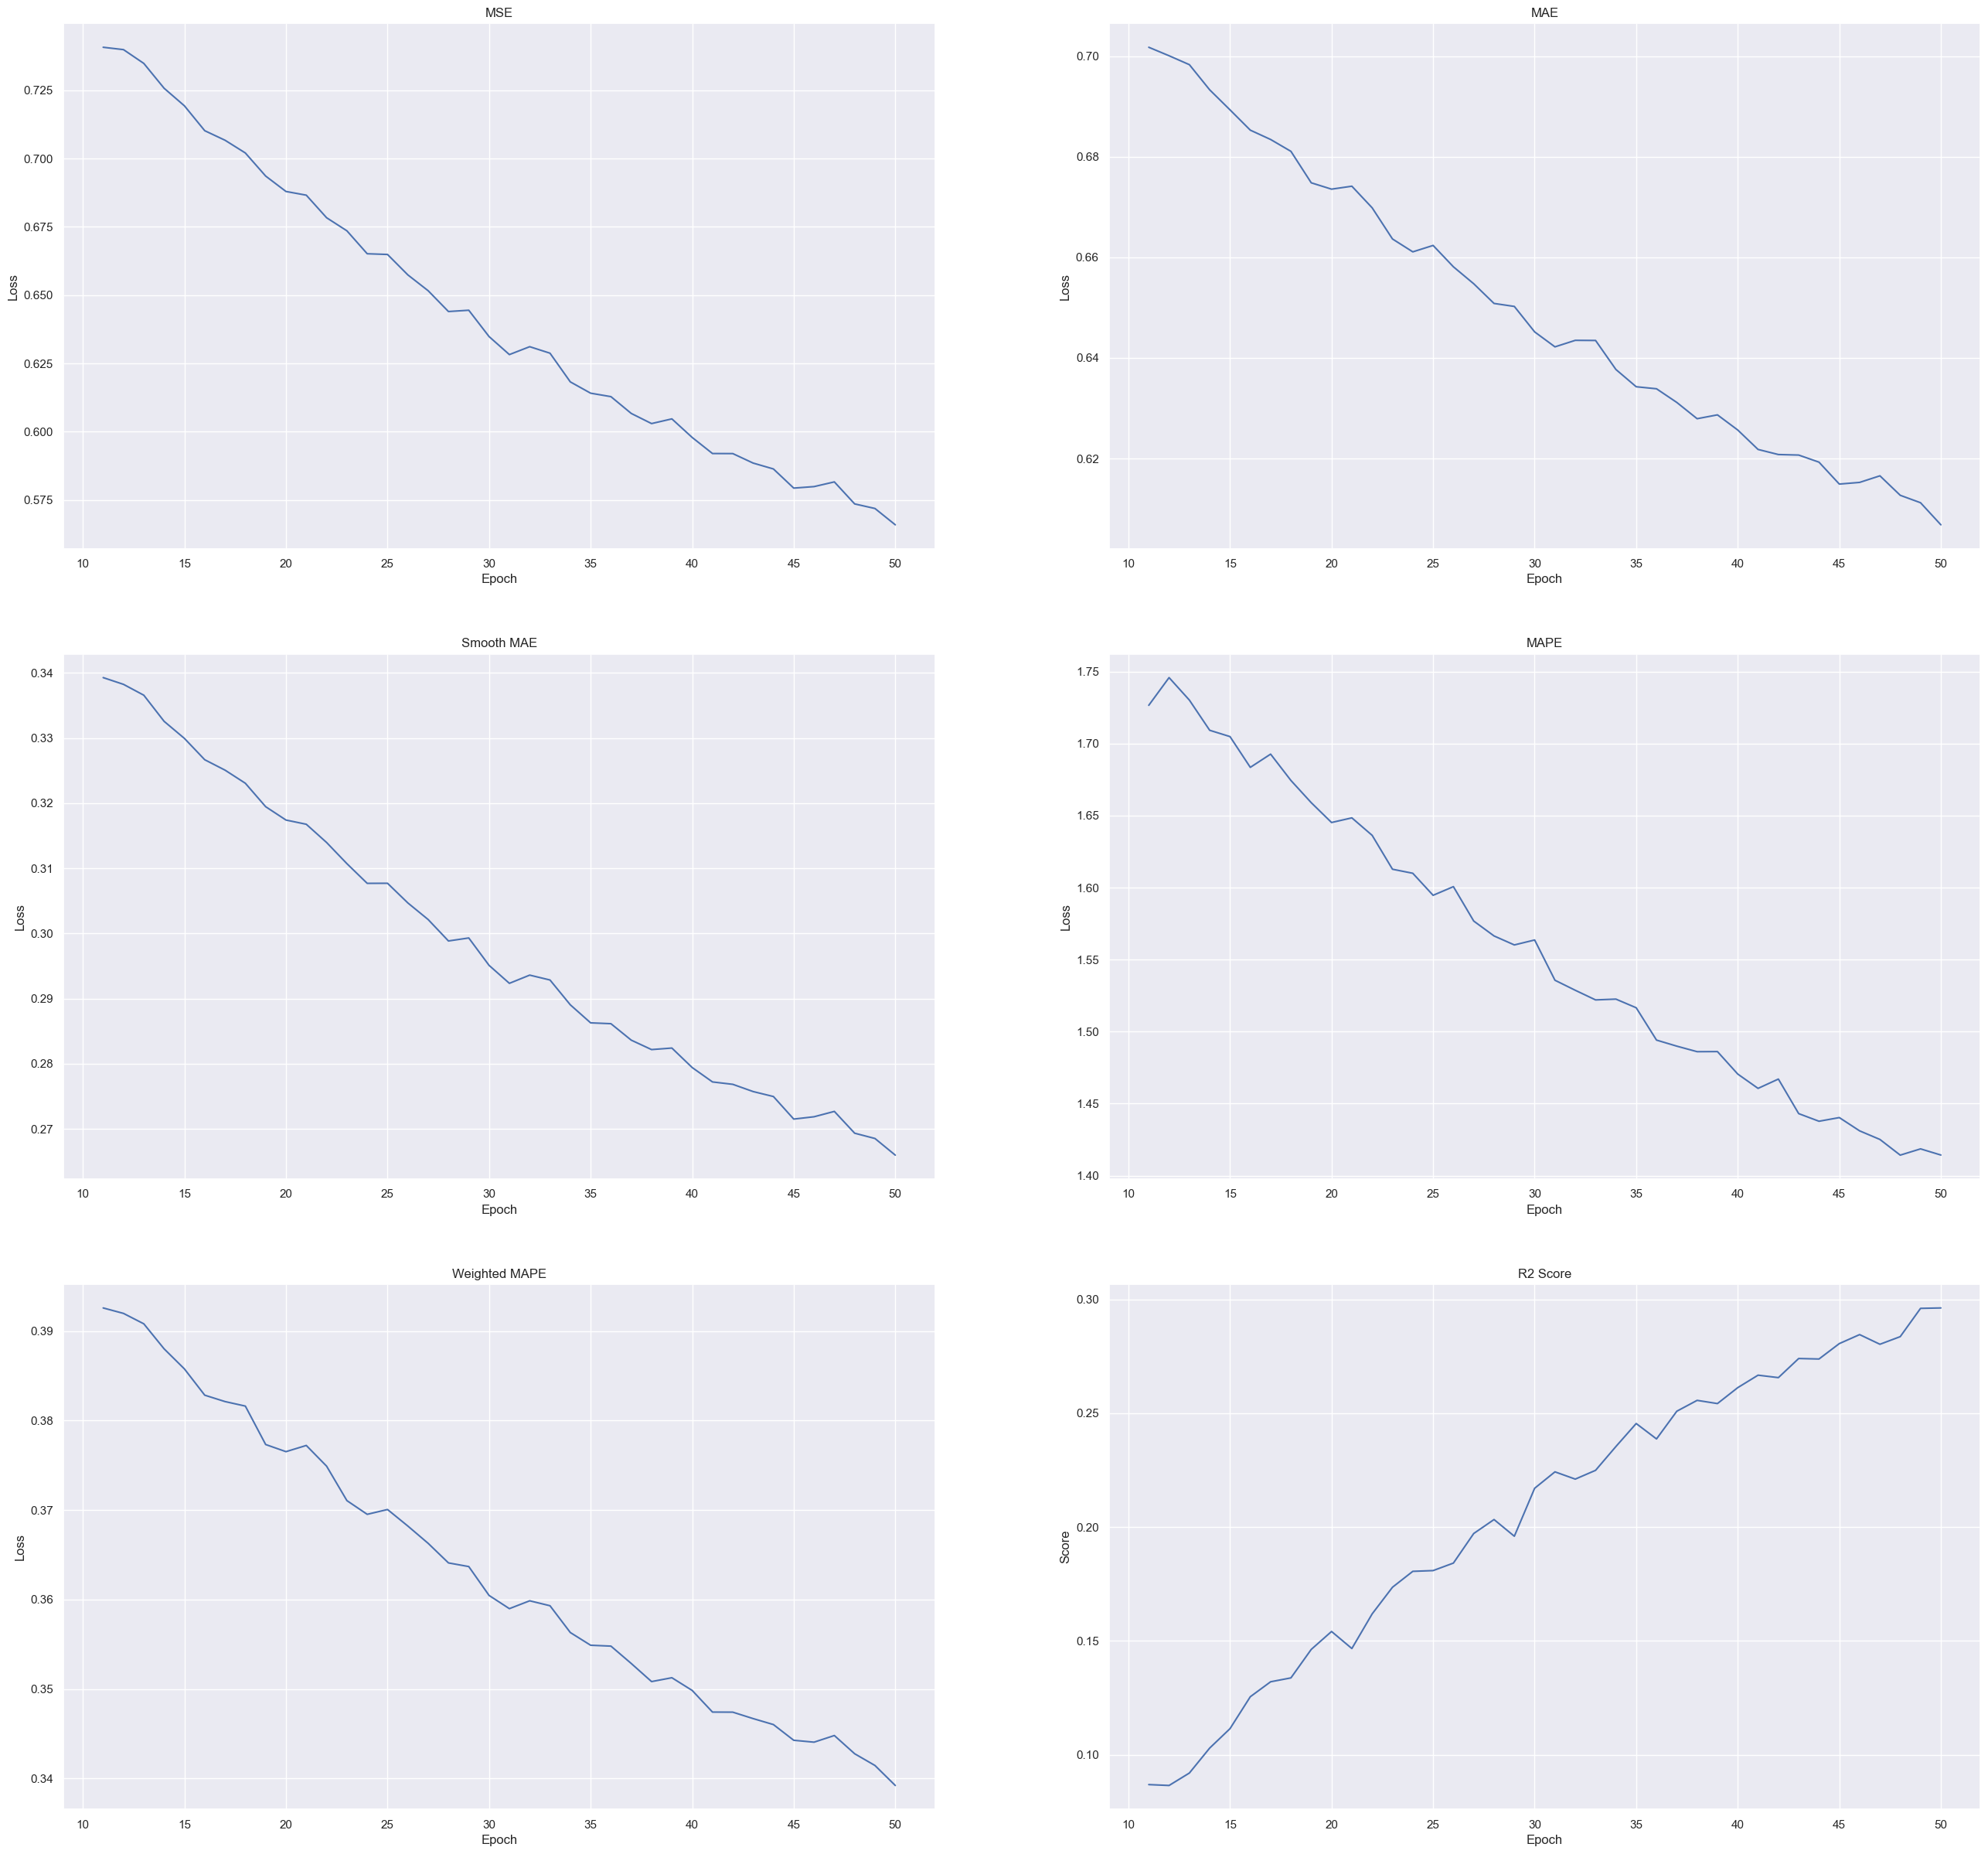

In [32]:
# Display the training metrics per batch

cnn_plot.show_metric_grid(
	report       = report,
	mode         = 'train',
	filename     = os.path.join(OUT_PLOT, model.__name__ + '-train'),
	apply_limits = False,
	start_index  = CONFIG['core/plots']
)

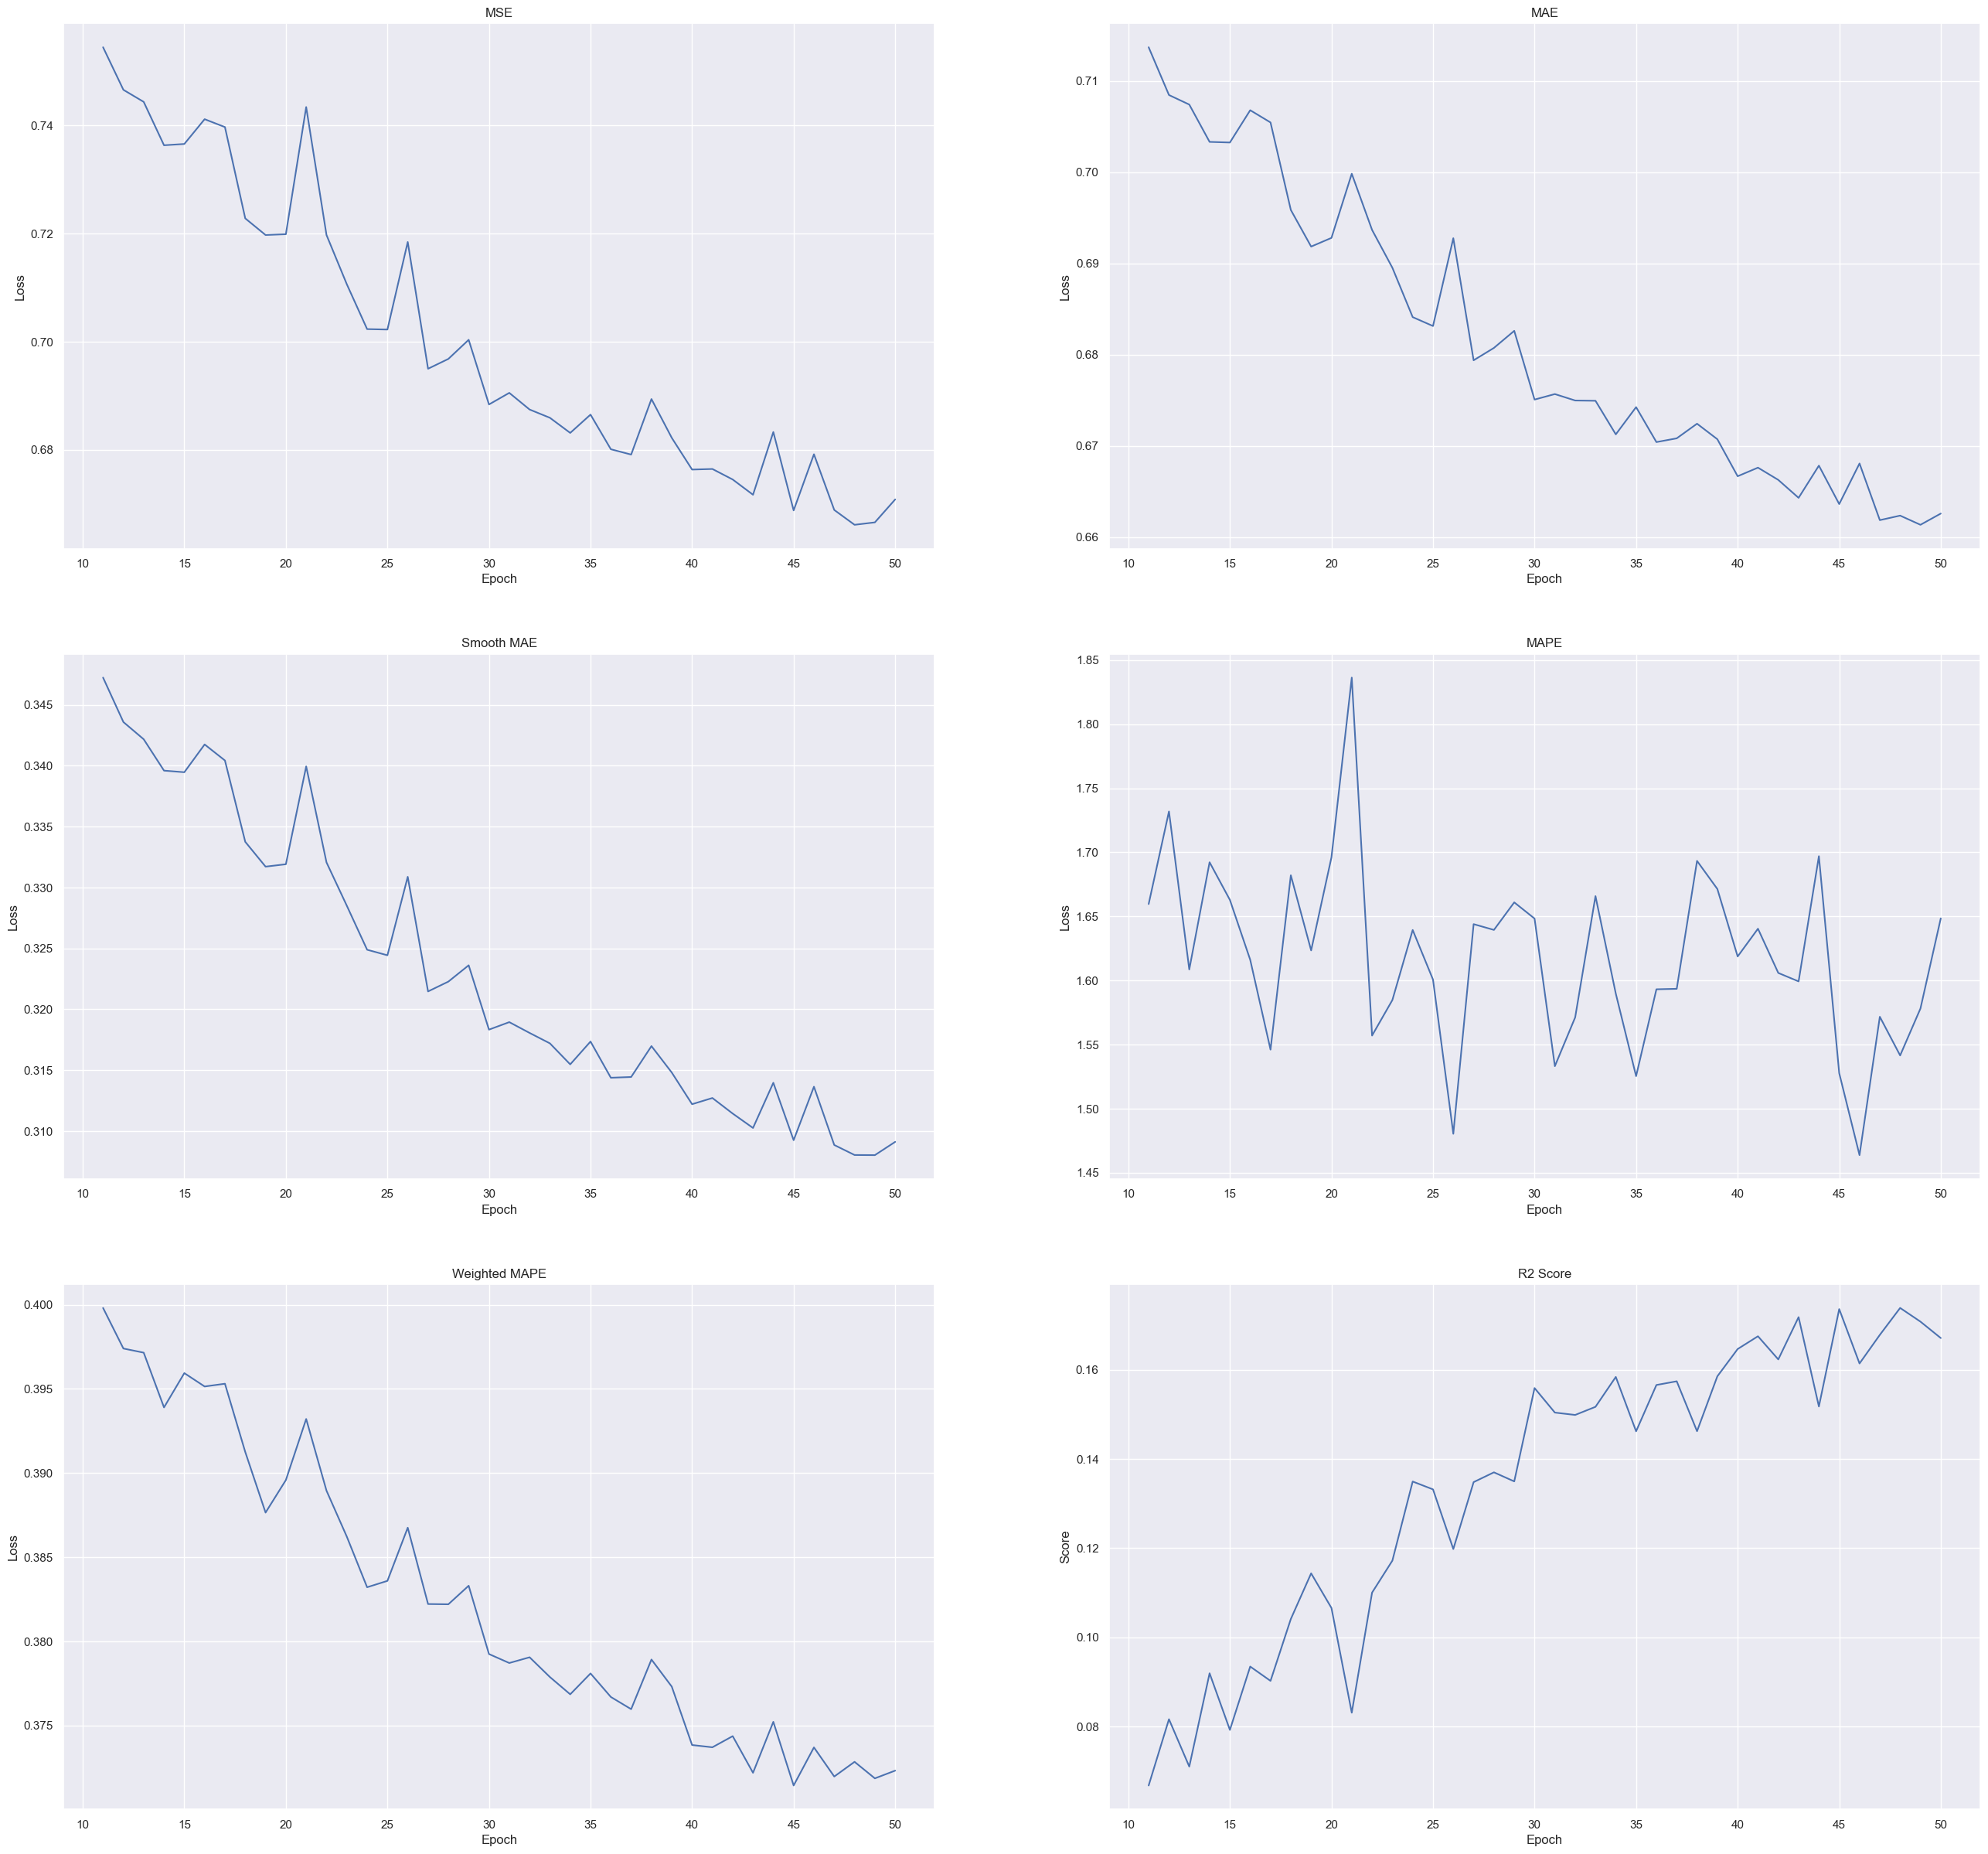

In [33]:
# Display the validation metrics per batch

cnn_plot.show_metric_grid(
	report       = report,
	mode         = 'valid',
	filename     = os.path.join(OUT_PLOT, model.__name__ + '-valid'),
	apply_limits = False,
	start_index  = CONFIG['core/plots']
)

# 5. Evaluation

## 5.1 Last Model

### 5.1.1 Evaluation

In [34]:
# Load last model

checkpoint = loader.load_torch(
	filename = os.path.join(OUT_MODEL, model.__name__ + '-last.pth')
)

final_report['evaluation/last/epoch'] = checkpoint['epoch']
final_report['evaluation/last/loss']  = checkpoint['loss']

print('Epoch : ' + '{}'.format(final_report['evaluation/last/epoch']))
print(' Loss : ' + '{:.5f}'.format(final_report['evaluation/last/loss']))
print()

model.load_state_dict(checkpoint['models'])

Epoch : 50
 Loss : 0.66155



<All keys matched successfully>

In [35]:
# Evaluate the full model on keep test

if CONFIG['model/mode'] == 'regression' :
	report_keep, final_report = cnn_model.eval_regressor_with_report(
		model  = model,
		params = model_params,
		report = final_report,
		mode   = 'evaluation/last/test'
	)

if CONFIG['model/mode'] == 'classification' :
	report_keep, final_report = cnn_model.eval_classifier_with_report(
		model  = model,
		params = model_params,
		report = final_report,
		mode   = 'evaluation/last/test'
	)

Mode   : evaluation/last/test
R2     :    0.18112
MAE    :    0.65596
MSE    :    0.65978
MAPE   :    1.61814
WMAPE  :    0.37308



## 5.2 Best Model

### 5.2.1 Evaluation

In [36]:
# Load best model

checkpoint = loader.load_torch(
	filename = os.path.join(OUT_MODEL, model.__name__ + '-best.pth')
)

final_report['evaluation/best/epoch'] = checkpoint['epoch']
final_report['evaluation/best/loss']  = checkpoint['loss']

print('Epoch : ' + '{}'.format(final_report['evaluation/best/epoch']))
print(' Loss : ' + '{:.5f}'.format(final_report['evaluation/best/loss']))
print()

model.load_state_dict(checkpoint['models'])

Epoch : 49
 Loss : 0.65746



<All keys matched successfully>

In [37]:
# Evaluate the full model on keep test

if CONFIG['model/mode'] == 'regression' :
	report_keep, final_report = cnn_model.eval_regressor_with_report(
		model  = model,
		params = model_params,
		report = final_report,
		mode   = 'evaluation/best/test'
	)

if CONFIG['model/mode'] == 'classification' :
	report_keep, final_report = cnn_model.eval_classifier_with_report(
		model  = model,
		params = model_params,
		report = final_report,
		mode   = 'evaluation/best/test'
	)

Mode   : evaluation/best/test
R2     :    0.19558
MAE    :    0.65421
MSE    :    0.65323
MAPE   :    1.54076
WMAPE  :    0.37077



### 5.2.2 Custom

In [38]:
# Display the first few evaluation item predictions and expectations

if CONFIG['model/mode'] == 'regression' :
	cnn_utils.display_regression_predictions(
		report = report_keep,
		n      = 2
	)

if CONFIG['model/mode'] == 'classification' :
	cnn_utils.display_classification_predictions(
		report = report_keep,
		n      = 2
	)

 Key : G1672
True : [ 1.93370]
Pred : [ 2.37537]
 MAE : [ 0.44167]
 MSE : [ 0.19507]
  R2 : [ 0.36454]

 Key : G0923
True : [ 1.36009]
Pred : [ 1.48488]
 MAE : [ 0.12479]
 MSE : [ 0.01557]
  R2 : [ 0.24466]



### 5.2.3 Visualization

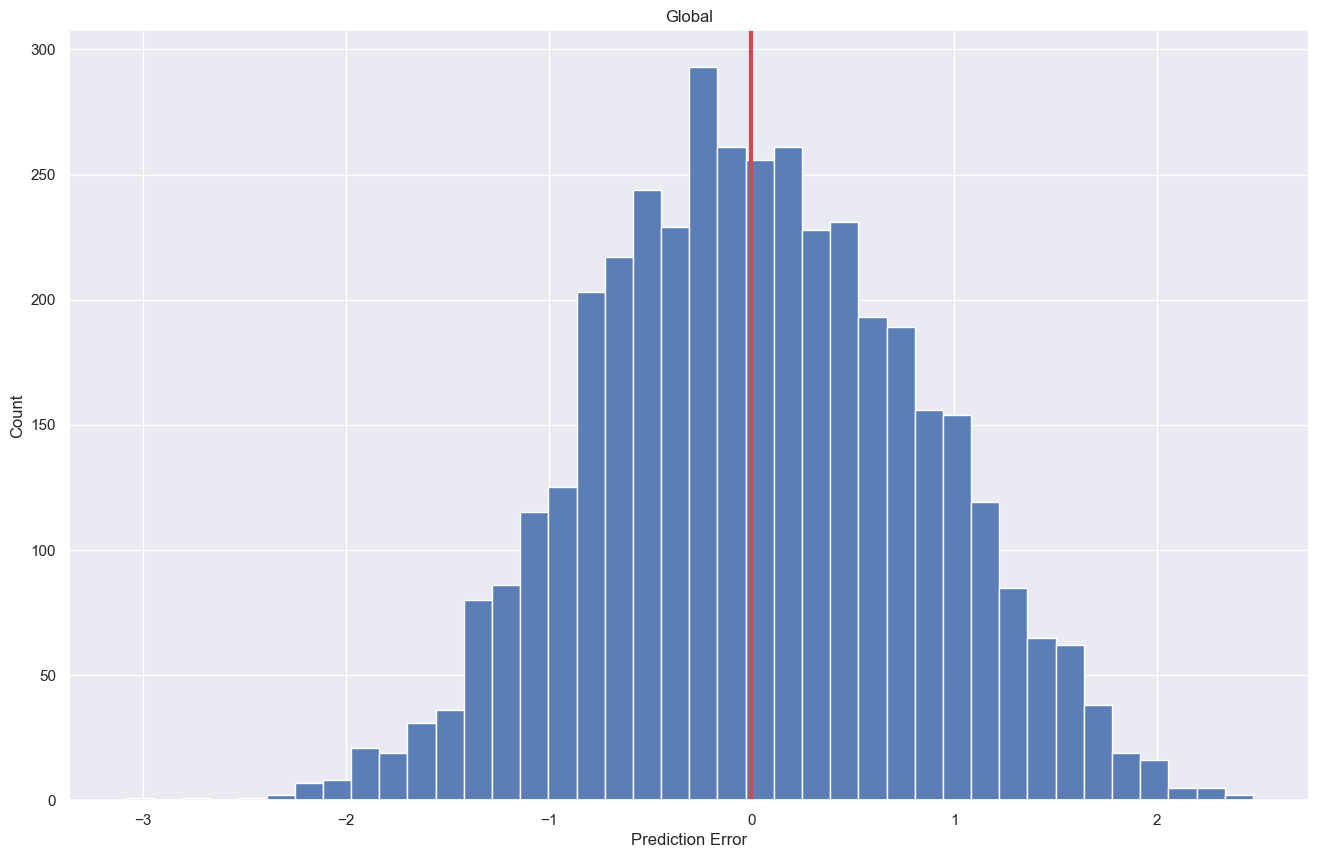

In [39]:
# Display prediction error per group

if CONFIG['model/mode'] == 'regression' :
	cnn_plot.show_prediction_error_grid(
		report   = report_keep,
		order    = target_order,
		filename = os.path.join(OUT_PLOT, model.__name__ + '-best')
	)

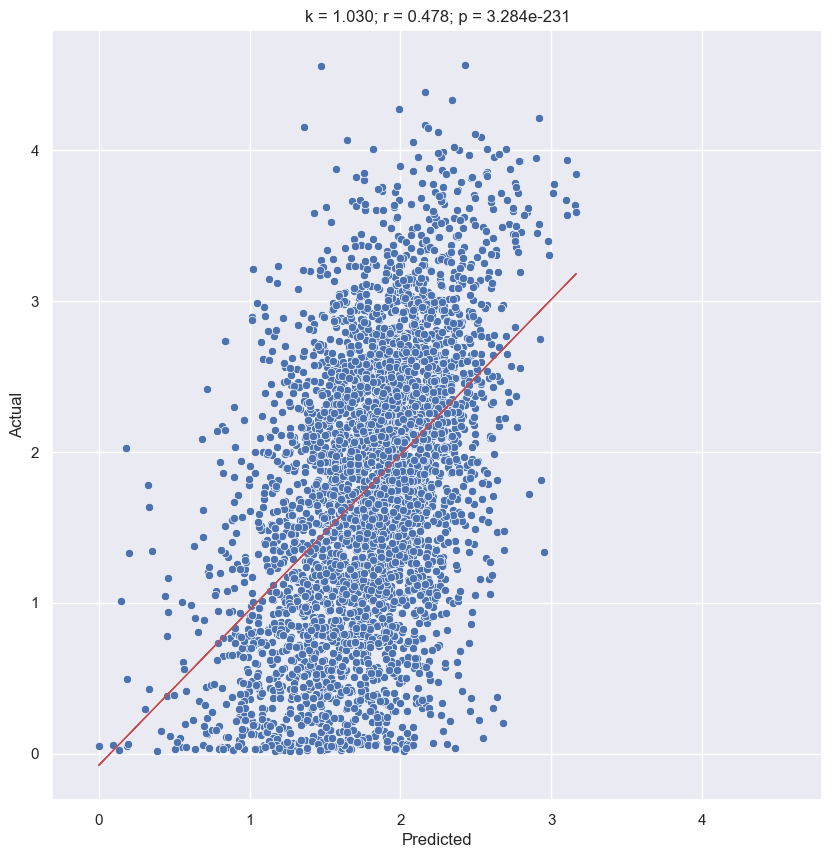

In [40]:
# Display prediction linear regression per group

if CONFIG['model/mode'] == 'regression' :
	cnn_plot.show_linear_regression_grid(
		report   = report_keep,
		order    = target_order,
		filename = os.path.join(OUT_PLOT, model.__name__ + '-best')
	)

# 6. Save

In [41]:
# Convert reports from numpy array to lists

def ensure_json_validity (item) :
	if   isinstance(item, dict)          : pass
	elif isinstance(item, list)          : return item
	elif isinstance(item, numpy.ndarray) : return item.tolist()
	elif isinstance(item, float)         : return item
	elif isinstance(item, int)           : return item
	elif isinstance(item, str)           : return item
	else                                 : return None

	data = dict()

	for key in item.keys() :
		data[key] = ensure_json_validity(item[key])

	return data

report_keep = ensure_json_validity(report_keep)

In [42]:
# Save results

for key, value in final_report.items() :
	if isinstance(value, numpy.float32) :
		final_report[key] = float(value)

writer.write_json(
	data     = final_report,
	filename = os.path.join(OUT_DATA, 'report.json')
)

writer.write_json(
	data     = report_keep,
	filename = os.path.join(OUT_DATA, 'report_keep.json')
)

writer.write_json(
	data     = {k : v for k, v in CONFIG.items() if k != 'core/device'},
	filename = os.path.join(OUT_DATA, 'config.json')
)